In [853]:

import os
import sys
import pandas as pd
import numpy as np
import create_dicts


code_path = os.getcwd()
data_path = "C:/Users/XHK/Desktop/thesis_code/events_analysis/data/raw/kaggle"

event_type1, event_type2, side, shot_place, shot_outcome, location, \
    bodypart, assist_method, situation = create_dicts.get_dictionaries()


weighted_attempts_filename = "events_w_weighted_french_logistic.csv" # "events_w_weighted_french.csv"
events = pd.read_csv('/'.join([data_path, weighted_attempts_filename]))
ginf = pd.read_csv('/'.join([data_path, "ginf.csv"]))

events_columns = ['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
                  'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
                  'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
                  'location', 'bodypart', 'assist_method', 'situation', 'fast_break']

ginf_columns = ['id_odsp', 'link_odsp', 'adv_stats', 'date', 'league', 'season',
                'country', 'ht', 'at', 'home_goals', 'away_goals', 'odd_h', 'odd_d', 'odd_a',
                'odd_over', 'odd_under', 'odd_bts', 'odd_bts_n'] 


Getting dictionaries to analyse events.csv


In [854]:
code_path

'c:\\Users\\XHK\\Desktop\\thesis_code\\events_analysis\\src\\features'

Some code to determine which league is best to start analysing: 

the variable ginf is a DataFrame created from a .csv which stores general info about each match in the 'events' dataset

We want detailed match-data, which means the match must have adv_stats == True

In [855]:
ginf.groupby(['adv_stats', 'league']).count()


id_odsp  link_odsp  date  season  country    ht    at  \
adv_stats league                                                          
False     D1           49         49    49      49       49    49    49   
          E0          820        820   820     820      820   820   820   
          F1           19         19    19      19       19    19    19   
          I1           18         18    18      18       18    18    18   
          SP1          24         24    24      24       24    24    24   
True      D1         1641       1641  1641    1641     1641  1641  1641   
          E0         1300       1300  1300    1300     1300  1300  1300   
          F1         2088       2088  2088    2088     2088  2088  2088   
          I1         2088       2088  2088    2088     2088  2088  2088   
          SP1        2065       2065  2065    2065     2065  2065  2065   

                  home_goals  away_goals  odd_h  odd_d  odd_a  odd_over  \
adv_stats league                                                          
False     D1              49          49     49     49     49         0   
          E0             820         820    820    820    820         0   
          F1              19          19     19     19     19         0   
          I1              18          18     18     18     18         0   
          SP1             24          24     24     24     24         0   
True      D1            1641        1641   1641   1641   1641       153   
          E0            1300        1300   1300   1300   1300       220   
          F1            2088        2088   2088   2088   2088       208   
          I1            2088        2088   2088   2088   2088       207   
          SP1           2065        2065   2065   2065   2065       189   

                  odd_under  odd_bts  odd_bts_n  
adv_stats league                                 
False     D1              0        0          0  
          E0              0        0          0  
          F1              0        0          0  
          I1              0        0          0  
          SP1             0        0          0  
True      D1            153      153        153  
          E0            220      220        220  
          F1            208      208        208  
          I1            207      207        207  
          SP1           189      189        189

France and Italy have the most matches with available events-data in the dataset. 
We pick the French league arbitrarily, moving forward.

first we want to have a column for home-goal-attempts and away-goal-attempts and add it to ginf. 
attempt has an event_type of 1

In [856]:
matches_no_stats_fr = ginf[(ginf.league == 'F1') & (ginf.adv_stats == False)]

matches_fr = ginf[(ginf.adv_stats == True) & (ginf.league == 'F1')]
events_fr = events.loc[events.id_odsp.isin(matches_fr.id_odsp)]



number of attempts by either team. own-goals are ignored.

We add the amount of attempts on goal by the home-team and by the away-team. 
There are around 12 NaN's in those columns. We will deal with them by using the average amount of attempts of the corresponding teams:

In [857]:

#matches_fr['home_attempts'] = np.nan
#matches_fr['away_attempts'] = np.nan

h_att = events_fr[(events_fr.event_type == 1) & (
        events_fr.side == 1) &(event_type2 != 15)].groupby('id_odsp').count()

a_att = events_fr[(events_fr.event_type == 1) & (
    events_fr.side == 2) & (event_type2 != 15)].groupby('id_odsp').count()



In [858]:
matches_fr.index = matches_fr.id_odsp
matches_fr = pd.concat([matches_fr,h_att.event_type],   axis = 1)
matches_fr = matches_fr.rename({'event_type':'home_attempts' }, axis='columns')
matches_fr = pd.concat([matches_fr,a_att.event_type],   axis = 1)
matches_fr = matches_fr.rename({'event_type':'away_attempts'}, axis='columns')

#matches_fr.head()



replacing NaNs  in Home_- and Away_attempts  with the average over all games (this causes minor information-leak from future values to past values, but only around 19 NaNs in the dataset)

In [859]:
home_nans = matches_fr[matches_fr.home_attempts.isna()]['ht']
away_nans = matches_fr[matches_fr.away_attempts.isna()]['at']


# homers = home_nans.values
# for team in homers:
#     matches_fr[matches_fr.ht == team].home_attempts.mean()
#home_nans

for game_id,team in home_nans.iteritems():
    mean_att = matches_fr[matches_fr.ht == team].home_attempts.mean()
    matches_fr.loc[matches_fr.id_odsp == game_id, 'home_attempts'] = mean_att
for game_id, team in away_nans.iteritems():
    mean_att = matches_fr[matches_fr['at'] == team].away_attempts.mean()
    matches_fr.loc[matches_fr.id_odsp == game_id, 'away_attempts'] = mean_att


We proceed by getting the amount of red card events:
In the events.csv, 'location'

First we define a helper function:  

In [860]:
def get_events(events, event_type_nr, type=1 ):
    event_type = 'event_type'
    if type != 1:
        event_type= 'event_type2'
    h_events = events[(events[event_type] == event_type_nr) & (
        events.side == 1)].groupby('id_odsp').count()


    a_events = events[(events[event_type] == event_type_nr) & (
        events.side == 2)].groupby('id_odsp').count()

    return h_events, a_events

def concat_and_rename(df_matches, home_vec, away_vec, name, type = 1):
    event_type = 'event_type'
    if type != 1:
        event_type = 'event_type2'
    

    home_name = 'home_'+name
    away_name = 'away_'+name 
    df_matches.index = df_matches.id_odsp

    df_matches = pd.concat([df_matches, home_vec[event_type]],   axis=1)
    df_matches = df_matches.rename({event_type: home_name}, axis='columns')
    df_matches = pd.concat([df_matches, away_vec[event_type]],   axis=1)
    df_matches = df_matches.rename({event_type: away_name}, axis='columns')

    # changing nans to zeroes:
    if name == 'offsides' or name == 'yellowcards':  # Offsides-variable displays NaN when no offside-events registered. 0 offsides is still realistic occurence.
        print(
            f"replacing {sum(df_matches[home_name].isna())} NaNs by {0} for event =  {name}")
        df_matches.loc[df_matches[home_name].isna(), home_name] = 0
        df_matches.loc[df_matches[away_name].isna(), away_name] = 0
        return df_matches
    else: #changing NaNs for some variables into the overall mean for that variable in the dataset
        print(f"replacing {sum(df_matches[home_name].isna())} NaNs by {int(df_matches[home_name].fillna(0).mean())} for event =  {name}")
        #print(f"{set(df_matches[df_matches[home_name].isna()]['ht'])}")
        df_matches.loc[df_matches[home_name].isna(), home_name] = int(
            df_matches[home_name].fillna(0).mean())
        df_matches.loc[df_matches[away_name].isna(), away_name] = int(
            df_matches[away_name].fillna(0).mean())
        return df_matches

home_redcard,away_redcard = get_events(events_fr, 6)
matches_fr = concat_and_rename(matches_fr, home_redcard, away_redcard, name = 'redcard')


replacing 1953 NaNs by 0 for event =  redcard


changing all the NaN's to 0 red_card values: 

Adding the 'conceded penalty' feature:       penalty_conceded has eventnumber 11

In [861]:
home_penalty_conceded, away_penalty_conceded = get_events(events_fr, 11)
matches_fr = concat_and_rename(    matches_fr, home_penalty_conceded, away_penalty_conceded, name='penalty_conceded')



replacing 1759 NaNs by 0 for event =  penalty_conceded


In [862]:
sum(matches_fr.home_redcard.isna())

#matches_fr.columns

0

adding columns for a home_sentoff and away_sentoff features

In [863]:
home_sent, away_sent = get_events(events_fr, 14, type=2)
matches_fr = concat_and_rename(    matches_fr, home_sent, away_sent, name='sentoff')


replacing 1886 NaNs by 0 for event =  sentoff


adding corner_taken features for both teams.   Corners conceded is lower for away team???

In [864]:
home_corner, away_corner = get_events(events_fr, 2, type = 1)
matches_fr = concat_and_rename(
    matches_fr, home_corner, away_corner, name='corners_taken')


replacing 38 NaNs by 5 for event =  corners_taken


fouls

In [865]:
home_fouls, away_fouls = get_events(events_fr, 3, type=1)
matches_fr = concat_and_rename(    matches_fr, home_fouls, away_fouls, name='fouls')


replacing 14 NaNs by 12 for event =  fouls


In [866]:
home_free_kicks, away_free_kicks = get_events(events_fr, 8 ,type=1 )
matches_fr = concat_and_rename(matches_fr, home_free_kicks, away_free_kicks, name = 'free_kicks')

replacing 14 NaNs by 13 for event =  free_kicks


In [867]:
home_handballs, away_handballs = get_events(events_fr, 10)
matches_fr = concat_and_rename(matches_fr, home_handballs, away_handballs, name = 'handballs')

replacing 1063 NaNs by 0 for event =  handballs


In [868]:
home_offsides, away_offsides = get_events(events_fr, 9)
matches_fr = concat_and_rename(
    matches_fr, home_offsides, away_offsides, name='offsides')


replacing 292 NaNs by 0 for event =  offsides


In [869]:
away_own_goal, home_own_goal  = get_events(events_fr, 15, type = 2)  #away, home switched around because an own_goal commited by home team, is credited to the 'side'-variable of away_team
matches_fr = concat_and_rename(
    matches_fr, away_own_goal, home_own_goal, name='own_goals')


replacing 1993 NaNs by 0 for event =  own_goals


In [870]:
home_yellows, away_yellows = get_events(events_fr, 4)
matches_fr = concat_and_rename(
    matches_fr, home_yellows, away_yellows, name='yellowcards')


replacing 327 NaNs by 0 for event =  yellowcards


[] Use shot-placement, location and isGoal to determine a weighting for attempts
    [use logistic-regression]
[] Make a weighted-attempts feature

In [871]:
#all the French attempt-events that did not end in own-goals 
french_attempt_events = events[(events.id_odsp.isin(matches_fr.id_odsp)) & (events.event_type ==1) & (events.event_type2 !=15)]
french_attempt_events.groupby('id_odsp side'.split()).sum()

home_weighted_attempts = french_attempt_events[french_attempt_events.side == 1].groupby(
    'id_odsp').sum().french_attempt_weight

away_weighted_attempts = french_attempt_events[french_attempt_events.side == 2].groupby('id_odsp').sum().french_attempt_weight

matches_fr = pd.concat([matches_fr, home_weighted_attempts],   axis=1)
matches_fr = matches_fr.rename(
    {'french_attempt_weight': 'home_weighted_attempts'}, axis='columns')
matches_fr = pd.concat([matches_fr, away_weighted_attempts],   axis=1)
matches_fr = matches_fr.rename(
    {'french_attempt_weight': 'away_weighted_attempts'}, axis='columns')

# changing nans to zeroes:
# matches_fr.loc[matches_fr[home_name].isna(), home_name] = 0
# matches_fr.loc[matches_fr[away_name].isna(), away_name] = 0


Possession-proxy features: 

events that get or need possession to occur: 
attempt, offside, corner, freekick, passing

events that are negatively associated with possession: 
foul, red card, yellow card, andball, penalty

Pass and assists analysis according to DSAA paper:

[1. DONE ] total assist-volume: assist-methods 1,2,3,4              proxy for omega    (passing volume)
[2. ] mean players passing volume (incl. substitutes)               mu_p  
[3. ] variance of players passing volume                            sigma_p 


In [872]:
# TOTAL ASSIST VOLUME PER MATCH

home_total_assists = events_fr[(events_fr['assist_method'] != 0) & (
    events_fr.side == 1)].groupby('id_odsp').count().assist_method

away_total_assists = events_fr[(events_fr['assist_method'] != 0) & (
    events_fr.side == 2)].groupby('id_odsp').count().assist_method

matches_fr = pd.concat([matches_fr, home_total_assists],   axis=1)
matches_fr = matches_fr.rename(
     {'assist_method': 'home_total_assists'}, axis='columns')
matches_fr = pd.concat([matches_fr, away_total_assists],   axis=1)
matches_fr = matches_fr.rename(
     {'assist_method': 'away_total_assists'}, axis='columns')

matches_fr.loc[matches_fr.home_total_assists.isna(), 'home_total_assists'] = 0
#sum(matches_fr.away_total_assists.isna())
matches_fr.loc[matches_fr.away_total_assists.isna(), 'away_total_assists'] = 0
# sum(matches_fr.away_total_assists.isna())


Fixing the NaNs in weighted_attempts by replacing them with the respective teams' mean weighted_attempts

In [873]:
matches_fr.isna().sum()

home_nans = matches_fr[matches_fr.home_weighted_attempts.isna()]['ht']
away_nans = matches_fr[matches_fr.away_weighted_attempts.isna()]['at']


# homers = home_nans.values
# for team in homers:
#     matches_fr[matches_fr.ht == team].home_attempts.mean()
#home_nans

for game_id, team in home_nans.iteritems():
    mean_att = matches_fr[matches_fr.ht == team].home_weighted_attempts.mean()
    matches_fr.loc[matches_fr.id_odsp == game_id, 'home_weighted_attempts'] = mean_att
for game_id, team in away_nans.iteritems():
    mean_att = matches_fr[matches_fr['at'] == team].away_weighted_attempts.mean()
    matches_fr.loc[matches_fr.id_odsp == game_id, 'away_weighted_attempts'] = mean_att


Adding attempt_weights that are rounded to nearest integer

In [874]:
matches_fr['home_weighted_attempts_discrete'] = matches_fr['home_weighted_attempts'].round(decimals = 0)
matches_fr['away_weighted_attempts_discrete'] = matches_fr['away_weighted_attempts'].round(
    decimals=0)


mean_assists 

In [875]:
matches_fr['home_goals home_weighted_attempts'.split()].corr().values[0,1].round(decimals = 4)

0.472

In [876]:
# home_mean_assists = home_total_assists.copy()/11
# away_mean_assists = away_total_assists.copy()/11

In [877]:

# home_assist_variance = pd.DataFrame(events_fr[(events_fr['assist_method'] != 0) & (events_fr['side'] == 1)].groupby(
#     'id_odsp event_team player2 '.split()).apply(lambda x: x.assist_method.count()).groupby('id_odsp').var())
# home_assist_variance.columns = ['home_assist_variance']
# home_assist_variance


In [878]:
home_assist_variance = pd.DataFrame(events_fr[(events_fr['assist_method'] != 0) & (events_fr['side'] == 1)].groupby(
    'id_odsp event_team player2 '.split()).apply(lambda x: x.assist_method.count()).groupby('id_odsp').var())
home_assist_variance.columns = ['home_assist_variance']

away_assist_variance = pd.DataFrame(events_fr[(events_fr['assist_method'] != 0) & (events_fr['side'] == 2)].groupby(
    'id_odsp event_team player2 '.split()).apply(lambda x: x.assist_method.count()).groupby('id_odsp').var())
away_assist_variance.columns = ['away_assist_variance']

matches_fr = pd.concat([matches_fr, home_assist_variance],   axis=1)
matches_fr = matches_fr.rename(
    {'assist_method': 'home_assist_variance'}, axis='columns')
matches_fr = pd.concat([matches_fr, away_assist_variance],   axis=1)
matches_fr = matches_fr.rename(
    {'assist_method': 'away_assist_variance'}, axis='columns')

# # changing nans to zeroes:
matches_fr.loc[matches_fr['home_assist_variance'].isna(), 'home_assist_variance'] = 0
matches_fr.loc[matches_fr['away_assist_variance'].isna(), 'away_assist_variance'] = 0


In [879]:
sum(matches_fr.home_offsides == 0)


292

Adding times of goals

In [880]:
 
ev = events_fr.copy()
home_goal_times = ev[(ev.id_odsp.isin(matches_fr.id_odsp)) & (ev['is_goal'] == 1) & (ev['side'] == 1)].groupby('id_odsp') 
away_goal_times = ev[(ev.id_odsp.isin(matches_fr.id_odsp)) & (
    ev['is_goal'] == 1) & (ev['side'] == 2)].groupby('id_odsp')


def extract_times(row):
    #print(row.time.values)
    goal_times = []
    if len(row.time.values) > 0:
        for t in row.time.values:
            goal_times.append(t)
    else:
        return []
    return goal_times


h = home_goal_times.apply(lambda x: extract_times(x))
matches_fr.loc[matches_fr.home_goals > 0, 'home_goal_times'] = h

a = away_goal_times.apply(lambda x: extract_times(x))
matches_fr.loc[matches_fr.away_goals > 0, 'away_goal_times'] = a


creating possession ensemble statistics: 
Possession = sum of attempts offsides, corners_taken and free_kicks in a match
Dispossession = sum of fouls, redcards, yellowcards  in a match

In [881]:
events_related_to_possession = 'attempts offsides corners_taken free_kicks '.split()
events_related_to_dispossession = 'fouls redcard yellowcards'.split()

home_possess, away_possess = [[side+event for event in events_related_to_possession] for side in ('home_', 'away_')]
home_dispossess, away_dispossess = [
    [side+event for event in events_related_to_dispossession] for side in ('home_', 'away_')]

matches_fr['home_possessions'] = matches_fr[home_possess].sum(axis = 'columns')
matches_fr['home_dispossessions'] = matches_fr[home_dispossess].sum(axis = 'columns')
#matches_fr[home_possession]
matches_fr['away_possessions'] = matches_fr[away_possess].sum(axis='columns')
matches_fr['away_dispossessions'] = matches_fr[away_dispossess].sum(
    axis='columns')


In [882]:
matches_fr['home_possession_percentage'] = 100 * matches_fr['home_possessions'] / (matches_fr['home_possessions'] + matches_fr['away_possessions'] ).round(decimals = 2)
matches_fr['away_possession_percentage'] = 100 * matches_fr['away_possessions'] / \
    (matches_fr['home_possessions'] +
     matches_fr['away_possessions'])

matches_fr['home_possdis_percentage'] = 100 *(matches_fr['home_possessions'] - \
                                         matches_fr['home_dispossessions']) / (matches_fr['home_possessions'] + matches_fr['away_possessions'] - matches_fr['home_dispossessions'] - matches_fr['away_dispossessions'])
matches_fr['away_possdis_percentage'] = 100 * (matches_fr['away_possessions'] -
                                               matches_fr['away_dispossessions']) / (matches_fr['home_possessions'] + matches_fr['away_possessions'] - matches_fr['home_dispossessions'] - matches_fr['away_dispossessions'])



In [883]:
def h_index(x, side ):
    #print(x)
    if side ==1:

        home_assists = np.clip(x['home_total_assists'], a_min=0.01, a_max=20)    
        home_std = np.clip(x['home_assist_variance'], a_min=0.01, a_max=10) 
        home_h_index = 2 / ((1/home_assists) + (1/home_std))
    
        return home_h_index 
    elif side ==2:
        away_assists = np.clip(x['away_total_assists'], a_min=0.01, a_max = 20)
        away_std = np.clip(x['away_assist_variance'], a_min=0.01, a_max = 10)
        away_h_index = 2 / ((1/away_assists) + (1/away_std))

        return away_h_index
    else: 
        error = print('CORRECT SIDE NOT SPECIFIED WHEN CALLING H-INDEX FUNCTION')
        return 

In [884]:
home_h_index = matches_fr.apply(lambda x: h_index(x, side = 1), axis = 'columns')
away_h_index = matches_fr.apply(lambda x: h_index(x, side=2), axis='columns')

matches_fr['home_h_index'] = home_h_index
matches_fr['away_h_index'] = away_h_index

In [885]:
matches_fr.columns

Index(['id_odsp', 'link_odsp', 'adv_stats', 'date', 'league', 'season',
       'country', 'ht', 'at', 'home_goals', 'away_goals', 'odd_h', 'odd_d',
       'odd_a', 'odd_over', 'odd_under', 'odd_bts', 'odd_bts_n',
       'home_attempts', 'away_attempts', 'home_redcard', 'away_redcard',
       'home_penalty_conceded', 'away_penalty_conceded', 'home_sentoff',
       'away_sentoff', 'home_corners_taken', 'away_corners_taken',
       'home_fouls', 'away_fouls', 'home_free_kicks', 'away_free_kicks',
       'home_handballs', 'away_handballs', 'home_offsides', 'away_offsides',
       'home_own_goals', 'away_own_goals', 'home_yellowcards',
       'away_yellowcards', 'home_weighted_attempts', 'away_weighted_attempts',
       'home_total_assists', 'away_total_assists',
       'home_weighted_attempts_discrete', 'away_weighted_attempts_discrete',
       'home_assist_variance', 'away_assist_variance', 'home_goal_times',
       'away_goal_times', 'home_possessions', 'home_dispossessions',
       'awa

PLOTTING CORRELATIONS OF ALL VARIABLES WITH THE ENDING SCORES 

In [891]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_of_interest = ['home_goals', 'away_goals','home_attempts',
'away_attempts', 'home_redcard', 'away_redcard',
'home_penalty_conceded', 'away_penalty_conceded', 'home_sentoff',
'away_sentoff', 'home_corners_taken', 'away_corners_taken',
'home_fouls', 'away_fouls', 'home_free_kicks', 'away_free_kicks',
'home_handballs', 'away_handballs', 'home_offsides', 'away_offsides',
'home_own_goals', 'away_own_goals', 'home_yellowcards',
                       'away_yellowcards', 'home_weighted_attempts', 'away_weighted_attempts', 
                       'home_weighted_attempts_discrete', 'away_weighted_attempts_discrete',
'home_total_assists', 'away_total_assists', 'home_assist_variance',
'away_assist_variance', 'home_goal_times', 'away_goal_times',
                       'home_possessions', 'home_dispossessions', 'away_possessions', 'home_possession_percentage',
                       'away_possession_percentage', 'home_possdis_percentage',
                       'away_possdis_percentage',
                       'away_dispossessions', 'home_h_index', 'away_h_index']

#matches_fr.plot.scatter(y='home_goals',
                #x='home_corners_taken')
#sns.regplot(matches_fr.home_goals, matches_fr.home_corners_taken, color='blue')
#matches_fr['home_goals home_sentoff'.split()].corr('pearson')

matches_fr[columns_of_interest].corr(method = 'pearson')
#sns.pairplot(matches_fr[columns_of_interest], y_vars=['home_weighted_attempts',                                                      'away_weighted_attempts', 'home_possessions', 'away_possessions'], x_vars=['home_goals', 'away_goals'])


,home_goals,away_goals,home_attempts,away_attempts,home_redcard,away_redcard,home_penalty_conceded,away_penalty_conceded,home_sentoff,away_sentoff,...,home_possessions,home_dispossessions,away_possessions,home_possession_percentage,away_possession_percentage,home_possdis_percentage,away_possdis_percentage,away_dispossessions,home_h_index,away_h_index
home_goals,1.000000,-0.045311,0.210013,-0.021398,-0.111471,0.110963,0.205377,0.076793,-0.115279,0.104279,...,0.086716,-0.050182,-0.022761,0.075110,-0.075110,0.035751,-0.035751,-0.049515,0.145449,-0.045685
away_goals,-0.045311,1.000000,-0.001399,0.258388,0.105534,-0.058085,0.084874,0.156946,0.119917,-0.061388,...,-0.024159,0.006045,0.125872,-0.103310,0.103310,-0.091500,0.091500,-0.053546,-0.024565,0.185140
home_attempts,0.210013,-0.001399,1.000000,-0.251267,-0.102431,0.108974,0.055758,0.011303,-0.132705,0.104602,...,0.744815,-0.119985,-0.275860,0.616042,-0.616042,0.434111,-0.434111,0.016089,0.491233,-0.100518
away_attempts,-0.021398,0.258388,-0.251267,1.000000,0.067944,-0.126309,0.020707,0.036944,0.109072,-0.146110,...,-0.302126,0.035821,0.721297,-0.641489,0.641488,-0.512939,0.512939,-0.129193,-0.106001,0.464012
home_redcard,-0.111471,0.105534,-0.102431,0.067944,1.000000,0.119524,0.020130,0.087177,0.829698,0.103678,...,-0.060665,0.047494,0.026813,-0.059325,0.059325,-0.026626,0.026626,0.066875,-0.045870,0.005407
away_redcard,0.110963,-0.058085,0.108974,-0.126309,0.119524,1.000000,0.197417,0.015497,0.098891,0.826324,...,0.092097,0.082821,-0.078603,0.107981,-0.107981,0.073696,-0.073696,0.068418,0.056437,-0.048567
home_penalty_conceded,0.205377,0.084874,0.055758,0.020707,0.020130,0.197417,1.000000,0.235618,0.009059,0.176355,...,0.019387,0.042757,0.006082,0.014557,-0.014557,-0.000849,0.000849,-0.001146,-0.002315,-0.023807
away_penalty_conceded,0.076793,0.156946,0.011303,0.036944,0.087177,0.015497,0.235618,1.000000,0.084096,0.038492,...,-0.010071,0.024843,0.003676,-0.011557,0.011557,-0.006143,0.006143,0.001812,-0.029541,-0.002212
home_sentoff,-0.115279,0.119917,-0.132705,0.109072,0.829698,0.098891,0.009059,0.084096,1.000000,0.111972,...,-0.097582,0.103399,0.062700,-0.102708,0.102708,-0.079181,0.079181,0.063442,-0.073361,0.019944
away_sentoff,0.104279,-0.061388,0.104602,-0.146110,0.103678,0.826324,0.176355,0.038492,0.111972,1.000000,...,0.115880,0.096671,-0.090366,0.129847,-0.129847,0.118509,-0.118509,0.143073,0.055511,-0.062817


In [887]:
a   = pd.concat([matches_fr.away_goals, np.floor(matches_fr.away_weighted_attempts)], axis = 1) 
a.corr()

,away_goals,away_weighted_attempts
away_goals,1.000000,0.473913
away_weighted_attempts,0.473913,1.000000


In [888]:
def scatterplot_correlation(col_names, data=matches_fr):
    x_name,y_name = col_names
    correlation = matches_fr[[x_name, y_name]].corr().values[0, 1].round(decimals=3)
    sns.stripplot(data=data, x = x_name, y = y_name)
    #plt.text(3+0.2, 4.5, f"Pearson-correlation: {correlation}", horizontalalignment='left',
             #size='medium', color='black', weight='semibold')
    plt.title(f"({x_name}, {y_name}): Pearson-correlation: {correlation}", weight = 'bold')

    return plt
    #plt.show()

relevant_columns = 'attempts redcard penalty_conceded weighted_attempts weighted_attempts_discrete total_assists assist_variance possessions h_index'.split()

relevant_home_names = [('home_goals','home_'+name) for name in relevant_columns] 
relevant_away_names = [('away_goals','away_'+name) for name in relevant_columns ]


fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\attempts.png


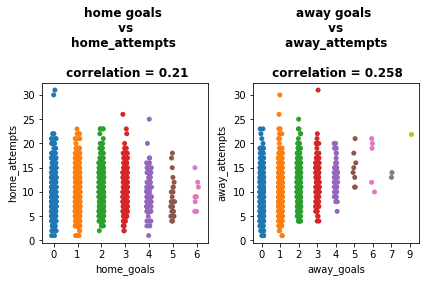

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\redcard.png


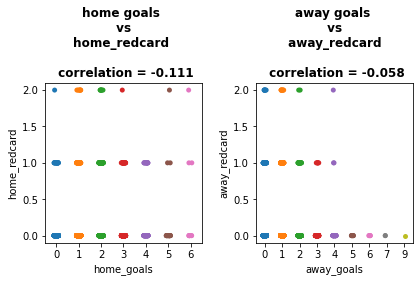

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\penalty_conceded.png


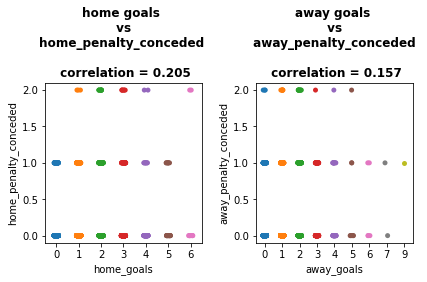

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\weighted_attempts.png


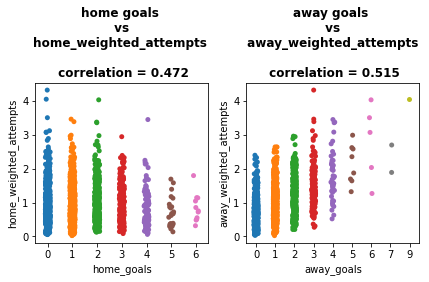

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\weighted_attempts_discrete.png


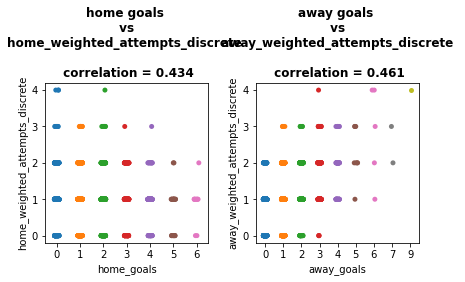

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\total_assists.png


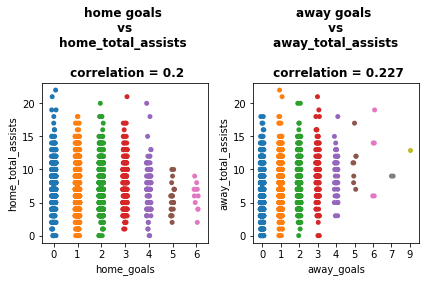

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\assist_variance.png


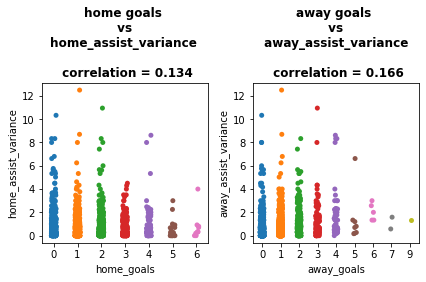

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\possessions.png


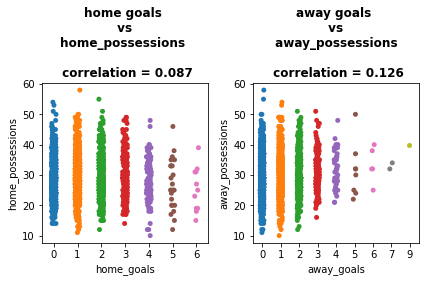

fname = c:\Users\XHK\Desktop\thesis_code\events_analysis\src\features\plots\h_index.png


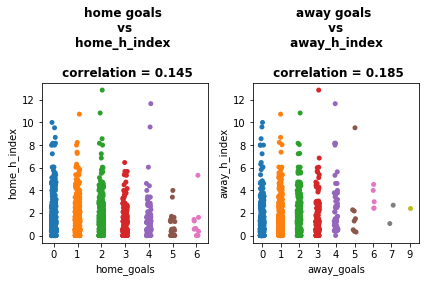

In [889]:
for name in relevant_columns:
    x_name_home, y_name_home = ('home_goals', 'home_'+name)
    x_name_away, y_name_away = ('away_goals', 'away_'+name)
    data = matches_fr
    figure, axes = plt.subplots(nrows = 1, ncols = 2)
    plt.subplot(1, 2, 1)
    sns.stripplot(data=data, x=x_name_home, y=y_name_away)
    plt.ylabel(y_name_home)
    plt.xlabel(x_name_home)
    correlation = matches_fr[[x_name_home, y_name_home]
                             ].corr().values[0, 1].round(decimals=3)
    plt.title(f"home goals \n vs \n{y_name_home} \n \n correlation = {correlation}" , weight = 'bold')

    plt.subplot(1, 2, 2)
    sns.stripplot(data=data, x=x_name_away, y=y_name_away)
    plt.ylabel(y_name_away)
    plt.xlabel(x_name_away)
    correlation = matches_fr[[x_name_away, y_name_away]
                             ].corr().values[0, 1].round(decimals=3)
    plt.title(f"away goals \n vs \n {y_name_away} \n \n correlation = {correlation}", weight = 'bold')
     
    
    figure.tight_layout(pad=1)

    current = os.getcwd()
    #os.mkdir(current+'\\plots\\')
    fname = current + '\\plots\\' + name + '.png' 
    print(f"fname = {fname}")
    plt.savefig(fname = fname, dpi = 300)
    plt.show()


In [890]:
import time 
def save_data(data, name):
    curr_time = str(time.monotonic())[:6]
    name+=curr_time
    name+='.csv'
    data.to_csv(name)

#save_data(matches_fr, 'processed_french_matches')